### Code Review

In [66]:
# Necessary import modules
import pandas as pd
import os
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
import math 
import us
import statsmodels.api as sm 

In [2]:
def deg2rad(degrees):
    rad_val = degrees*(math.pi/180)
    return(rad_val)

# First, this function accepts two lat-long pairs in decimal values.
def calc_distance(lat1, lon1, lat2, lon2):
    
# Second, this function calculates the radius of the earth in nautical miles using the equation on pp3.
# 1.852 * (180*60/pi)= 6366.707019493709km.  However, Task 5 asks for the distance in nautical miles so we divide
# simply do eliminate the kilometers from the equation.
    earth_radiusNM = 180*60/math.pi
    
# Third, this function converts the decimal degree into a radian value.    
    lat1 = deg2rad(lat1)
    lon1 = deg2rad(lon1)
    lat2 = deg2rad(lat2)
    lon2 = deg2rad(lon2)
    
# Fourth, the function calculates the distance using the function provided in the text.    
    distance_val = earth_radiusNM *(math.acos(math.sin(lat2) * math.sin(lat1) + math.cos(lat2) * math.cos(lat1) * math.cos(abs(lon1 - lon2))))
    return distance_val

In [3]:
df=pd.read_csv("Hospitals.csv",encoding="iso-8859-1",usecols=['LATITUDE','LONGITUDE','NAME','CITY','STATE','COUNTY','BEDS','TYPE'])
data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv', sep=",", encoding='iso-8859-1')

In [4]:
US_data=data.loc[data['Country/Region']=='US']
un=US_data["Province/State"].unique()
p = re.compile(r"\w[A-Z]+[A-Z]+$")

states=set()
for element in un:
    print(element)
    a=re.findall('[A-Z][A-Z]',element)
    if len(a)>0:
        states.add(a[0])

state_list=[]

for item in US_data['Province/State']:
    flag=False
    for element in states:
        if element in item:
            state_list.append(element)
            flag=True
    if flag==False:
        state_list.append('N/A')

US_data['State']=state_list
print(len(US_data))

King County, WA
Cook County, IL
Los Angeles, CA
San Benito, CA
Madison, WI
San Diego County, CA
San Antonio, TX
Omaha, NE (From Diamond Princess)
Travis, CA (From Diamond Princess)
Lackland, TX (From Diamond Princess)
Humboldt County, CA
Sacramento County, CA
Unassigned Location (From Diamond Princess)
Snohomish County, WA
Grafton County, NH
Hillsborough, FL
Placer County, CA
San Mateo, CA
Sarasota, FL
Sonoma County, CA
Umatilla, OR
Fulton County, GA
Washington County, OR
 Norfolk County, MA
Maricopa County, AZ
Wake County, NC
Westchester County, NY
Orange County, CA
Contra Costa County, CA
Bergen County, NJ
Harris County, TX
San Francisco County, CA
Clark County, NV
Fort Bend County, TX
Grant County, WA
Santa Rosa County, FL
Williamson County, TN
New York County, NY
Unassigned Location, WA
Montgomery County, MD
Suffolk County, MA
Denver County, CO
Summit County, CO
Chatham County, NC
Delaware County, PA
Douglas County, NE
Fayette County, KY
Marion County, IN
Middlesex County, MA
Nassa

C:\Users\david\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
#County data needed to get center point locations of counties
counties_df = pd.read_csv("2019_Gaz_counties_national.txt", sep='\t',usecols=[0,1,3,8,9 ])
counties_df = counties_df.rename(columns={"USPS": "STATE", "NAME": "COUNTY" })
counties_df = counties_df.rename(columns={'INTPTLAT':"Lat",'INTPTLONG':"Long"})
counties_df.rename(columns={counties_df.columns[4]: "Long" }, inplace = True)

counties_df

,STATE,GEOID,COUNTY,Lat,Long
0,AL,1001,Autauga County,32.532237,-86.646440
1,AL,1003,Baldwin County,30.659218,-87.746067
2,AL,1005,Barbour County,31.870253,-85.405104
3,AL,1007,Bibb County,33.015893,-87.127148
4,AL,1009,Blount County,33.977358,-86.566440
...,...,...,...,...,...
3215,PR,72145,Vega Baja Municipio,18.455128,-66.397883
3216,PR,72147,Vieques Municipio,18.125418,-65.432474
3217,PR,72149,Villalba Municipio,18.130718,-66.472244
3218,PR,72151,Yabucoa Municipio,18.059858,-65.859871


In [6]:
# Creates a 'cities_df' that contains both city and county names.  The data from Johns Hopkins 
# contains both city and county names so merging the dataframes isn't as simple as city-to-city
# or county-to-county.
# Code sourced from https://simplemaps.com/data/us-cities
cities_df = pd.read_csv("uscities.csv", encoding='iso-8859-1', usecols=['city', 'county_fips', 'county_name', 'density', 'state_id']) 
cities_df.set_index('state_id', inplace = True) # Sets the index to state for future comparison
cities_df.sort_index(ascending = True, inplace = True) # Sorts them lowest to highest

cities_df

,city,county_fips,county_name,density
state_id,,,,
AK,Pitkas Point,2158,Kusilvak,30.0
AK,Egegik,2164,Lake and Peninsula,1.0
AK,Hughes,2290,Yukon-Koyukuk,10.0
AK,Akhiok,2150,Kodiak Island,3.0
AK,Homer,2122,Kenai Peninsula,159.0
...,...,...,...,...
WY,Bessemer Bend,56025,Natrona,59.0
WY,Shell,56003,Big Horn,57.0
WY,Veteran,56015,Goshen,20.0


In [7]:
df2 = pd.read_csv("Hospitals.csv",encoding="iso-8859-1", usecols=['LATITUDE','LONGITUDE', 'NAME','CITY','STATE','ZIP', 'BEDS','TYPE'])

# Zip code data need to match data to counties
zip2 = pd.read_csv("zip_code_database.csv")
zip_code = pd.read_csv("zip_code_database.csv", usecols = ['zip','county'])
zip_code = zip_code.rename(str.upper, axis='columns')

# get number of beds for each county
hosp=pd.merge(df2, zip_code, on = 'ZIP', how= 'left')
hosp=pd.merge(hosp, counties_df, on = ['STATE','COUNTY'], how= 'left')
hosp=hosp[hosp['BEDS'] >= 1] #The CAH designation is designed to reduce the financial vulnerability of rural hospitals and improve access to healthcare by keeping essential services in rural communities. To accomplish this goal, CAHs receive certain benefits, such as cost-based reimbursement for Medicare services
county_beds = hosp[hosp['TYPE'] != 'PSYCHIATRIC'] # remove Other type of hospitals seem fine for the purpose of this study
county_beds = hosp[["GEOID","BEDS"]]
county_beds=county_beds.groupby("GEOID").sum().reset_index()
county_beds.rename(columns = {'GEOID': 'County_Fips'}, inplace = True) # Renames the column header to 'County_Fips'
county_beds.County_Fips = county_beds.County_Fips.astype(int) # Casts the columns as integers
county_beds

,County_Fips,BEDS
0,1001,85
1,1003,398
2,1005,74
3,1007,35
4,1009,40
...,...,...
2512,72099,106
2513,72113,354
2514,72127,491
2515,72145,150


In [8]:
census_df = pd.read_csv("cc-est2018-alldata.csv", encoding='iso-8859-1', usecols=['STNAME', 'CTYNAME', 'YEAR', 'AGEGRP', 'TOT_POP']) 

# Year 11 (JUL18) is the most recent population estimate as per the data dictionary
census_df = census_df.query('YEAR == 11')

 # Converts Year 11 to an easier to the date when the data was published
census_df.loc[census_df['YEAR'] == 11, 'YEAR'] = 'JUL2018'

# Converts each AGEGRP category to age ranges
census_df.loc[census_df['AGEGRP'] == 0, 'AGEGRP'] = 'Total'
census_df.loc[census_df['AGEGRP'] == 1, 'AGEGRP'] = 'Age 0 to 4 years'
census_df.loc[census_df['AGEGRP'] == 2, 'AGEGRP'] = 'Age 5 to 9 years'
census_df.loc[census_df['AGEGRP'] == 3, 'AGEGRP'] = 'Age 10 to 14 years'
census_df.loc[census_df['AGEGRP'] == 4, 'AGEGRP'] = 'Age 15 to 19 years'
census_df.loc[census_df['AGEGRP'] == 5, 'AGEGRP'] = 'Age 20 to 24 years'
census_df.loc[census_df['AGEGRP'] == 6, 'AGEGRP'] = 'Age 25 to 29 years'
census_df.loc[census_df['AGEGRP'] == 7, 'AGEGRP'] = 'Age 30 to 34 years'
census_df.loc[census_df['AGEGRP'] == 8, 'AGEGRP'] = 'Age 35 to 39 years'
census_df.loc[census_df['AGEGRP'] == 9, 'AGEGRP'] = 'Age 40 to 44 years'
census_df.loc[census_df['AGEGRP'] == 10, 'AGEGRP'] = 'Age 45 to 49 years'
census_df.loc[census_df['AGEGRP'] == 11, 'AGEGRP'] = 'Age 50 to 54 years'
census_df.loc[census_df['AGEGRP'] == 12, 'AGEGRP'] = 'Age 55 to 59 years'
census_df.loc[census_df['AGEGRP'] == 13, 'AGEGRP'] = 'Age 60 to 64 years'
census_df.loc[census_df['AGEGRP'] == 14, 'AGEGRP'] = 'Age 65 to 69 years'
census_df.loc[census_df['AGEGRP'] == 15, 'AGEGRP'] = 'Age 70 to 74 years'
census_df.loc[census_df['AGEGRP'] == 16, 'AGEGRP'] = 'Age 75 to 79 years'
census_df.loc[census_df['AGEGRP'] == 17, 'AGEGRP'] = 'Age 80 to 84 years'
census_df.loc[census_df['AGEGRP'] == 18, 'AGEGRP'] = 'Age 85 years or older'
census_df.rename(columns = {'CTYNAME': 'County'}, inplace = True) # Renames the column header to 'County'

# Creates a pivot table where the value is the total population, the indexes are the county
# and state names and the columns are the respective age groups.
population_pivot_table = census_df.pivot_table( index = ['STNAME', 'County'], values = 'TOT_POP', columns = 'AGEGRP')
# Based off of media reports and historical data, the youth and eldery are more susceptible to 
# diseases. Therefore, the values are aggregated for '0-14 years' and '65 and above'
population_pivot_table['Age 0-14 Years'] = population_pivot_table['Age 10 to 14 years'] + population_pivot_table['Age 0 to 4 years'] + population_pivot_table['Age 5 to 9 years']
population_pivot_table['Age 65 and Above'] = population_pivot_table['Age 65 to 69 years'] + population_pivot_table['Age 70 to 74 years'] + population_pivot_table['Age 75 to 79 years'] + population_pivot_table['Age 80 to 84 years'] + population_pivot_table['Age 85 years or older']
population_pivot_table.drop(population_pivot_table.columns[0:18], axis = 1, inplace = True) # Removes the remaining/unnecessary age groups
population_pivot_table.rename(columns = {'Total':'Total Population'}, inplace = True) # Renames the 'Total' column to 'Total Population'

population_pivot_table

AGEGRP                     Total Population  Age 0-14 Years  Age 65 and Above
STNAME  County                                                               
Alabama Autauga County                55601           10669              8653
        Baldwin County               218022           38738             44571
        Barbour County                24881            4241              4832
        Bibb County                   22400            3782              3690
        Blount County                 57840           10997             10548
...                                     ...             ...               ...
Wyoming Sweetwater County             43051            9415              5214
        Teton County                  23081            3586              3558
        Uinta County                  20299            4868              2858
        Washakie County                7885            1418              1710
        Weston County                  6967            1204              1429

[3142 rows x 3 columns]

In [9]:
density_df = pd.read_csv("DEC_10_SF1_GCTPH1.US05PR_with_ann.csv", skiprows=1, encoding = "iso-8859-1", usecols=["Target Geo Id2", "Density per square mile of land area - Population"])
density_df.drop(density_df.index[0], inplace = True) # Removes the 'United States' Row
density_df.rename(columns = {'Target Geo Id2': 'County'}, inplace = True) # Renames the column header to 'County'
density_df['County'] = density_df.County.astype(int) # Converts to a float for comparison

# Hard-coded for 'Oglala County' which was known as Shannon County until May 2015
i = 0 # initialize a counter
while i < len(density_df): # Iterate over each county in US
    if density_df.iat[i,0] == 46113.0: # Boolean check for the original, Shannon County ID number
        density_df.iat[i,0] = 46102.0 # Replace with the new, Oglala County ID number
    i += 1 # Increment a counter

# Hard-coded for 'Kusilvak Census Area' which was known as Wade Hampton Census Area
i = 0 # initialize a counter
while i < len(density_df): # Iterate over each county in US
    if density_df.iat[i,0] == 02270.0: # Boolean check for the original, Wade Hampton Census Area ID number
        density_df.iat[i,0] = 02158.0  # Replace with the new, Kusilvak Census Area number
    i += 1 # Increment a counter

density_df

,County,Density per square mile of land area - Population
1,1,94.4
2,1001,91.8
3,1003,114.6
4,1005,31.0
5,1007,36.8
...,...,...
3269,72145,1301.1
3270,72147,183.2
3271,72149,731.6
3272,72151,687.2


In [10]:
# Reads in a csv that contains poverty data per county
poverty_df = pd.read_csv("SAIPESNC_03MAR20_01_15_59_26.csv", encoding='iso-8859-1', usecols=['State / County Name', 'All Ages in Poverty Count', 'County ID']) 
#poverty_df = poverty_df.apply(pd.to_numeric, errors='coerce')
poverty_df.drop(poverty_df.index[0], inplace = True) # Removes the 'United States' Row
poverty_df.rename(columns = {'State / County Name': 'County'}, inplace = True) # Renames the column header to 'County'
poverty_df.rename(columns = {'All Ages in Poverty Count': 'Poverty_Count'}, inplace = True) # Renames the column header to 'County'

poverty_df

,County ID,County,Poverty_Count
1,1000,Alabama,"801,758"
2,1001,Autauga County (AL),"7,587"
3,1003,Baldwin County (AL),"21,069"
4,1005,Barbour County (AL),"6,788"
5,1007,Bibb County (AL),"4,400"
...,...,...,...
3189,56037,Sweetwater County (WY),"3,540"
3190,56039,Teton County (WY),"1,443"
3191,56041,Uinta County (WY),"2,010"
3192,56043,Washakie County (WY),918


In [11]:
unemployment_df = pd.read_csv('laucntycur14.txt', sep = r"|", skiprows = (0,1,2,3,4), dtype=object, encoding="iso-8859-1")
unemployment_df.reset_index(inplace = True) # Resets the index
unemployment_df.set_index('level_0', inplace = True) # Sets index to County Fips Code

# Strips out any whitespace
# Code sourced from https://stackoverflow.com/questions/40950310/strip-trim-all-strings-of-a-dataframe
unemployment_df.replace('(^\s+|\s+$)', '', regex=True, inplace=True)

# Creates a column 'State' with the postal code
unemployment_df['State'] = unemployment_df.level_3.str.extract('\,\s(\w\w)').astype(str)

# Removes the (Postal Code) from each entry
unemployment_df['County'] = unemployment_df.level_3.str.replace(r'\,\s\w\w' , '', regex = True)

# Hard-coded for Juneau, Sitka, Wrangell, and Yakutat in Alaska
unemployment_df['County'] = unemployment_df['County'].str.replace('Borough/city', 'City and Borough', regex = True)
unemployment_df['County'] = unemployment_df['County'].str.replace('/city', '', regex = True)
unemployment_df['County'] = unemployment_df['County'].str.replace('/town', '', regex = True)
# Hard-coded for Anchorage
unemployment_df['County'] = unemployment_df['County'].str.replace('Borough/municipality', 'Municipality', regex = True)

# Only keeps the most recent unemployment percentage
unemployment_df.drop_duplicates(subset ="level_3", keep = 'last', inplace = True)
unemployment_df.rename(columns={'--------------------------------------------------------------------------------------------------------------------------------------': 'Unemployment_Rate'}, inplace = True)

# Since Washington D.C. is not a state, a hard-coded state of DC must be applied for future merge
# operations.
i = 0 # initialize a counter
while i < len(unemployment_df): # Iterate over the length of each county
    if unemployment_df.iat[i,9] == 'District of Columbia': # Boolean test for 'District of Columbia'
        unemployment_df.iat[i,8] = 'DC' # Insert DC for 'State'
    i += 1 # increment the counter

# Hard Coded due to Doña Ana County's uniquenes with the 'ñ'.  It gets stripped when the file gets
# read in but needs to be carried through for proper merge operations.
i = 0 # Initialize a counter
while i < len(unemployment_df): # iterate the length of unemployment_df (3142)
    if unemployment_df.iat[i,9] == 'Dona Ana County': # Boolean check for 'Dona Ana County'
        unemployment_df.iat[i,9] = 'Doña Ana County' # Replaces the county name for data lookup
    i += 1 #increment the counter

# Merge unemployment_df and counties_df
unemployment_df = pd.merge(unemployment_df, counties_df, left_on = ['County', 'State'], right_on = ['COUNTY', 'STATE'], how = 'left')

# Removes columns/rows we do not need
unemployment_df.drop(['level_1', 'level_2', 'level_3', 'level_4', 'level_5', 'level_6', 'level_7', 'STATE', 'Lat', 'Long'], axis = 1, inplace = True)

i = 0 # Initialize a counter
while i < len(unemployment_df): # Iterate over each county
    # Change the postal abbreviation code to the full spelling
    unemployment_df.iat[i,1] = str(us.states.lookup(str(unemployment_df.iat[i,1])))
    i += 1 # Increment the counter

# Filters out Puerto Rico
unemployment_df = unemployment_df[~unemployment_df['State'].str.contains("Puerto Rico")]

unemployment_df.set_index('COUNTY', inplace = True) # Sets index to 'County'
unemployment_df.dropna(inplace = True) # Drops NA values

unemployment_df

,Unemployment_Rate,State,County,GEOID
COUNTY,,,,
Autauga County,2.3,Alabama,Autauga County,1001.0
Baldwin County,2.4,Alabama,Baldwin County,1003.0
Barbour County,3.2,Alabama,Barbour County,1005.0
Bibb County,2.5,Alabama,Bibb County,1007.0
Blount County,2.3,Alabama,Blount County,1009.0
...,...,...,...,...
Sweetwater County,4.3,Wyoming,Sweetwater County,56037.0
Teton County,2.9,Wyoming,Teton County,56039.0
Uinta County,3.7,Wyoming,Uinta County,56041.0


In [12]:
##################################### master_df script ########################################

master_df = pd.merge(counties_df, density_df, left_on = 'GEOID', right_on = 'County', how = 'left')
master_df.drop('GEOID', axis = 1, inplace = True) # Drop unnecessary columns
master_df = pd.merge(master_df, poverty_df, left_on = 'County', right_on = 'County ID', how = 'left')
master_df.dropna(axis = 0, how = 'any', inplace = True) # Drop unnecessary rows
master_df.drop('County_x', axis = 1, inplace = True) # Drop unnecessary columns
master_df.drop('County_y', axis = 1, inplace = True) # Drop unnecessary columns

i = 0 # Initialize a counter
while i < len(master_df): # Iterate over each Corona virus case
    #Change the postal abbreviation code to the full spelling
    master_df.iat[i,0] = us.states.lookup(master_df.iat[i,0])
    i += 1 # Increment the counter

master_df['STATE'] = master_df['STATE'].astype(str) # Sets the column type to string for merging

master_df = pd.merge(master_df, population_pivot_table, left_on = ['STATE', 'COUNTY'], right_on = ['STNAME','County'], how = 'left')
master_df.drop('Lat', axis = 1, inplace = True) # Drop unnecessary columns
master_df.drop('Long', axis = 1, inplace = True) # Drop unnecessary columns
master_df = pd.merge(master_df, unemployment_df, left_on = ['County ID'], right_on = ['GEOID'], how = 'left')
master_df.drop('State', axis = 1, inplace = True) # Drop unnecessary columns
master_df.drop('GEOID', axis = 1, inplace = True) # Drop unnecessary columns
master_df = pd.merge(master_df, county_beds, left_on = 'County ID', right_on = 'County_Fips', how = 'left')
master_df.drop('County_Fips', axis = 1, inplace = True) # Drop unnecessary columns
master_df.set_index('COUNTY', inplace = True)
master_df.drop('County', axis = 1, inplace = True) # Drop unnecessary columns

# Code sourced from https://stackoverflow.com/questions/39125665/cannot-convert-string-to-float-in-pandas-valueerror
master_df['Poverty_Count'] = (master_df['Poverty_Count'].str.split()).apply(lambda x: float(x[0].replace(',', '')))

# Sourced from https://healthblog.uofmhealth.org/wellness-prevention/updated-information-on-covid-19-what-can-you-do-to-protect-against-coronavirus
R_o = 0.03 # Transmittal rate from one infected person per 100 people

# Creates an empty column for risk formulation
master_df['Risk Factor'] = np.nan

# After careful research and discussion, the following were selected as weight factors for our 
# risk analysis.
weight_factors = [10, 8, 6, 3]
normalized_weight_factors = []
i = 0 # Initialize a counter
while i < len(weight_factors): # Increment over the list of weighted factors
    # Normalizes the data
    normalized_weight_factors.append(weight_factors[i] / sum(weight_factors)) 
    i += 1 # Increments the counter
    
i = 0 # Initialize a counter
while i < len(master_df): # Iterate over the list of US Counties
    if pd.isna(master_df.iat[i,8]) == True: # Boolean check for 'NaN' as some entries have missing values
        master_df.iat[i,8] = 0         # Replace the hospital beds as NaN to 0
    i +=1 # Increment the counter

master_df['Unemployment_Rate'] = master_df['Unemployment_Rate'].astype(float) # Sets the column type to string for merging

master_df['Risk Factor'] = master_df['Density per square mile of land area - Population'] * R_o * normalized_weight_factors[0]
master_df['Risk Factor'] += (master_df['Age 65 and Above'] / master_df['Total Population'] + master_df['Age 0-14 Years'] / master_df['Total Population']) * normalized_weight_factors[1]
master_df['Risk Factor'] -= (master_df['BEDS'] / master_df['Total Population']) * normalized_weight_factors[2]
master_df['Risk Factor'] += (master_df['Poverty_Count'] / master_df['Total Population'] + (((master_df['Unemployment_Rate']/100) * master_df['Total Population'])/ master_df['Total Population'])) * normalized_weight_factors[3]

i = 0 # Initialize a counter
while i < len(master_df): # Iterate over the length of master_df (each county in the US)
    # Take the log of the column to normalize the data
    master_df.iat[i, -1] = math.log10(master_df.iat[i, -1])
    i += 1 # Increment the counter

master_df.to_csv('master_df.csv')

master_df

##################################### master_df script ########################################

,STATE,Density per square mile of land area - Population,County ID,Poverty_Count,Total Population,Age 0-14 Years,Age 65 and Above,Unemployment_Rate,BEDS,Risk Factor
COUNTY,,,,,,,,,,
Autauga County,Alabama,91.8,1001.0,7587.0,55601,10669,8653,2.3,85.0,0.057036
Baldwin County,Alabama,114.6,1003.0,21069.0,218022,38738,44571,2.4,398.0,0.145989
Barbour County,Alabama,31.0,1005.0,6788.0,24881,4241,4832,3.2,74.0,-0.313633
Bibb County,Alabama,36.8,1007.0,4400.0,22400,3782,3690,2.5,35.0,-0.274104
Blount County,Alabama,88.9,1009.0,7527.0,57840,10997,10548,2.3,40.0,0.047278
...,...,...,...,...,...,...,...,...,...,...
Sweetwater County,Wyoming,4.2,56037.0,3540.0,43051,9415,5214,4.3,115.0,-0.794064
Teton County,Wyoming,5.3,56039.0,1443.0,23081,3586,3558,2.9,48.0,-0.795054
Uinta County,Wyoming,10.1,56041.0,2010.0,20299,4868,2858,3.7,225.0,-0.624070


In [13]:
# Re-reads in the csv that contains poverty data per county
poverty_df = pd.read_csv("SAIPESNC_03MAR20_01_15_59_26.csv", encoding='iso-8859-1', usecols=['State / County Name', 'All Ages in Poverty Count']) 
#poverty_df = poverty_df.apply(pd.to_numeric, errors='coerce')
poverty_df.drop(poverty_df.index[0], inplace = True) # Removes the 'United States' Row
poverty_df.rename(columns = {'State / County Name': 'County'}, inplace = True) # Renames the column header to 'County'
poverty_df.rename(columns = {'All Ages in Poverty Count': 'Poverty_Count'}, inplace = True) # Renames the column header to 'County'

# Only grabs counties/boroughs since they contain a (followed by a state postal code), i.e. (AL)
poverty_df = poverty_df[poverty_df['County'].str.contains('\(')]

# Creates a column 'State' with the postal code
poverty_df['State'] = poverty_df.County.str.extract('.*\((.*)\).*')

# Removes the (Postal Code) from each entry
poverty_df['County'] = poverty_df.County.str.replace('\s\(\w\w\)' , '', regex = True)
poverty_df.set_index('County', inplace = True) # Sets the index to County for collaboration

i = 0 # Initialize a counter
while i < len(poverty_df): # Iterate over the length of poverty_df (each county)
    # Replaces the postal code with state name
    poverty_df.iat[i,1] = us.states.lookup(poverty_df.iat[i,1])
    i += 1 # Increment the counter

# Code sourced from https://stackoverflow.com/questions/43187436/pandas-dataframe-str-replace-function-replaces-floats-to-nan
# Removes ',' and concatenates the string to one contiguous line then converts it to a float
poverty_df['Poverty_Count'] = poverty_df.Poverty_Count.str.replace(",", "").astype(float)
poverty_df

,Poverty_Count,State
County,,
Autauga County,7587.0,Alabama
Baldwin County,21069.0,Alabama
Barbour County,6788.0,Alabama
Bibb County,4400.0,Alabama
Blount County,7527.0,Alabama
...,...,...
Sweetwater County,3540.0,Wyoming
Teton County,1443.0,Wyoming
Uinta County,2010.0,Wyoming


In [14]:
################################# US_data Script ########################################

US_data.rename(columns = {'Province/State': 'City_or_County'}, inplace = True) # Renames the column header to 'City_or_County'

# Code sourced from https://stackoverflow.com/questions/12065885/filter-dataframe-rows-if-value-in-column-is-in-a-set-list-of-values
# Removes the passengers who were sick and stuck on any cruise ship as they cannot affect anyone on
# land until they return to their hometowns.
US_data = US_data[~US_data['City_or_County'].str.contains("Cruise")]
US_data = US_data[~US_data['City_or_County'].str.contains("cruise")]
US_data = US_data[~US_data['City_or_County'].str.contains("Princess")]

# As of 10MAR20, Johns Hopkins also began cumulatively tracking cases by states.  These counts must
# be factored out in order to get an accurate representation of each county.
# Code sourced from https://python-forum.io/Thread-list-of-US-states
list_of_states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

i = 0 # Initialize a counter
while i < len(US_data): # Iterate over each case of Coronavirus
    US_data.iat[i,0] = US_data.iat[i,0].strip() # Strip out any whitespace from the state name
#    print(US_data.iat[i,0])
    j = 0 # Initialize a counter
    while j < len(list_of_states):
        if (US_data.iat[i,0] == list_of_states[j]) or US_data.iat[i,-1] == 'N/A':
            ################ Create new dataframe for states
            US_data.drop(US_data.index[i], inplace = True)
        j += 1 # increment a counter
    i += 1 # Increment a counter

# Removes the comma and state abbreviation (i.e. ', AL') from the element for future merge operations
US_data['City_or_County'] = US_data.City_or_County.str.replace(',\s\w\w' , '', regex = True)

i = 0 # Initialize a counter
while i < len(US_data): # Iterate over the list of US cities with corona virus cases
    US_data.iat[i,0] = US_data.iat[i,0].strip() # Strip out any whitespace from city/county
    US_data.iat[i,1] = US_data.iat[i,1].strip() # Strip out any whitespace from state
    if pd.isna(US_data.iat[i,-2]) == True: # Boolean check for 'NaN' as some entries have missing values
        # Replace the current day's values with those that are from the day before. -2 as the 
        # 'state' is -1 and -3 is two days ago.
        US_data.iat[i,-2] = US_data.iat[i,-3]
    i +=1 # Increment the counter
    
US_data.set_index('State', inplace = True) # Sets the index to state for future comparison
US_data.sort_index(ascending = True, inplace = True) # Sorts them lowest to highest

# Remove 'County' from each word for direct comparison 
US_data['City_or_County'] = US_data['City_or_County'].str.replace(" County", "")

# Hard Coded due to New York's uniquenes as both the city and county name.  Cities like San Francisco
# and Philadelphia that are both cities and county seats do not have this issue as "City" is not in
# the city name
i = 0 # Initialize a counter
while i < len(US_data.at['NY','City_or_County']): # iterate the elements with NY as an index
    if US_data.at['NY','City_or_County'][i] == 'New York City': # Boolean check for 'New York City'
        US_data.at['NY','City_or_County'][i] = 'New York' # Replaces NYC for New York for data lookup
    i += 1 #increment the counter
    
i = 0 # Initialize a counter
while i < len(US_data): # Iterate over the length of US_data (i.e. every US county with a case)
    j = 0 # Initialize a counter
    while j < len(cities_df): # Iterate over the entire length of the cities_df (i.e. every city in the USA)
        if (US_data.index[i] == cities_df.index[j]) and (US_data.iat[i,0] == cities_df.iat[j,2]):
            # Replaces the city name with the county name
            print("County and city names match:", US_data.iat[i,0])
            US_data.iat[i,0] = cities_df.iat[j, 2] + ' County'
        # Boolean test to check if a city/state combo in the dataframe is in the master list
        elif (US_data.iat[i,0] == cities_df.iat[j,0]) and (US_data.index[i] == cities_df.index[j]):
            print("Replacing city name", US_data.iat[i,0], "with", cities_df.iat[j,2])
            US_data.iat[i,0] = cities_df.iat[j,2] + ' County'
        j += 1 # increment the counter
    i += 1 # Increment the counter 
    
# Some locations inputted into the Johns Hopkins data are incorrectly located.  For example: mispelled,
# labelled as "Unassigned location", those that actually cities but they labelled as counties, etc.
# These misfit locations are then put into a dataframe so they may be accounted for appropriately.
locations_that_dont_conform = US_data[~US_data['City_or_County'].str.contains('County')]
    
new_list = [] # Empty list for storage
i = 0 # Initialize a counter
while i < len(locations_that_dont_conform): # Iterate over the length of US_data (i.e. every US county with a case)
    temp_list = [] # empty list for storage for each city that does not match a city or county
    j = 0 # Initialize a counter
    # Accounts for those who have 'Unassigned Location' etc. as their location
    while j < len(counties_df): # Iterate over every county in the US
        # Calculates the distance from the specified point to the center of each county 
        # appends it to a temporary list
        temp_list.append([calc_distance(locations_that_dont_conform.iat[i,2], locations_that_dont_conform.iat[i,3], counties_df.iat[j,3], counties_df.iat[j,4]), counties_df.iat[j,2], counties_df.iat[j,1], counties_df.iat[j,0]]) 
        j +=1 # Increment the counter
    new_list.append(temp_list)
    i += 1 # Increment the counter

i = 0 # Initialize a counter
# Iterate over the newly modified only_cities_df that contains county names
while i < len(locations_that_dont_conform):     
    # Grab the county name associated with the minimum distance to the county center
    locations_that_dont_conform.iat[i,0] = min(new_list[i])[1]
    i += 1 # # Increment the counter

# Concats the original US_data with the new recently found county names
US_data = pd.concat([US_data, locations_that_dont_conform])
# Removes the original, unknown location
US_data.drop_duplicates('Lat', keep = 'last',inplace = True) 

US_data.rename(columns = {'City_or_County': 'County'}, inplace = True) # Renames the columns
US_data.rename(columns = {'Country/Region': 'Country'}, inplace = True)  # Renames the columns

US_data.reset_index(inplace = True) # Resets the index
i = 0 # Initialize a counter
while i < len(US_data): # Iterate over each Corona virus case
    #Change the postal abbreviation code to the full spelling
    US_data.iat[i,0] = us.states.lookup(US_data.iat[i,0])
    i += 1 # Increment the counter

i = 0 # Initialize a counter
while i < len(US_data): # Iterate over the list of US Counties
    if US_data.iat[i,1] == 'District of Columbia': # Boolean check for D.C.
        #.loc['District of Columbia','State'] = 'District of Columbia'
        US_data.iloc[i,0] = 'District of Columbia' # Replace "None" for D.C.
    i +=1 # Increment the counter    

US_data['State'] = US_data['State'].astype(str) # Sets the column type to string for merging
US_data = pd.merge(US_data, master_df, left_on = ['County', 'State'], right_on = [master_df.index, 'STATE'], how = 'left')
US_data.drop('STATE', axis = 1, inplace = True) # Drop excess columns
#US_data.drop('GEOID', axis = 1, inplace = True) # Drop excess columns
US_data.set_index('County', inplace = True) # Sets the index to County

############ Re-calculation of the risk factors to include current coronavirus cases in each 
############ respective county

# Sourced from https://healthblog.uofmhealth.org/wellness-prevention/updated-information-on-covid-19-what-can-you-do-to-protect-against-coronavirus
R_o = 0.03 # Transmittal rate from one infected person per 100 people

# After careful research and discussion, the following were selected as weight factors for our 
# risk analysis.
weight_factors = [10, 8, 6, 3]
normalized_weight_factors = []
i = 0 # Initialize a counter
while i < len(weight_factors): # Increment over the list of weighted factors
    # Normalizes the data
    normalized_weight_factors.append(weight_factors[i] / sum(weight_factors)) 
    i += 1 # Increments the counter
    
i = 0 # Initialize a counter
while i < len(US_data): # Iterate over each corona virus case
    j = 0 # Initialize a counter
    # Computing transmittal rate based off of population density
    US_data.iat[i, -1] = US_data.iat[i, -9] * R_o * US_data.iat[i,-10] * normalized_weight_factors[j]
    
    j += 1 # Increments the normalizing coefficient counter
    # (Elderly population / total population + Youth / elderly population) * Weighting Factor
    US_data.iat[i, -1] += (US_data.iat[i, -4] / US_data.iat[i, -6] + US_data.iat[i, -5] / US_data.iat[i, -6]) * normalized_weight_factors[j]
    
    j += 1 # Increments the normalizing coefficient counter
    # Subtracting hospital beds per county per total population
    US_data.iat[i, -1] -= US_data.iat[i, -2] / US_data.iat[i, -6] * normalized_weight_factors[j]
    
    j += 1 # Increments the normalizing coefficient counter
    # (Poverty_count / total population + unemployment rate (converted to a decimal) * the total population / total_population) * Weighting Factor
    US_data.iat[i, -1] += (US_data.iat[i, -7] / US_data.iat[i, -6] + (((US_data.iat[i,-3]/100) * US_data.iat[i,-6]) / US_data.iat[i,-6])) * normalized_weight_factors[j]

    # Use log to transform skewed data into an approximate normal distribution
    US_data.iat[i,-1] = math.log10(US_data.iat[i, -1])
    
    i += 1 # Increment the counter

########################### Recalculation complete #################################

#US_data.to_csv("US_data-Wren.csv")

US_data

#################################### US_data Script ######################################

C:\Users\david\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


County and city names match: Maricopa
County and city names match: Pinal
County and city names match: Riverside
County and city names match: Contra Costa
County and city names match: Orange
County and city names match: Yolo
County and city names match: Madera
County and city names match: Sonoma
County and city names match: Shasta
County and city names match: Placer
County and city names match: Alameda
County and city names match: San Mateo
County and city names match: Sacramento
County and city names match: Humboldt
County and city names match: Fresno
County and city names match: San Diego
County and city names match: San Benito
County and city names match: Los Angeles
County and city names match: Santa Clara
County and city names match: San Francisco
County and city names match: Summit
County and city names match: Douglas
County and city names match: El Paso
County and city names match: Denver
County and city names match: Fairfield
County and city names match: Volusia
County and city 

,State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/20,Density per square mile of land area - Population,County ID,Poverty_Count,Total Population,Age 0-14 Years,Age 65 and Above,Unemployment_Rate,BEDS,Risk Factor
County,,,,,,,,,,,,,,,,,,,,,
Maricopa County,Arizona,US,33.2918,-112.4291,0,0,0,0,1,1,...,3.0,414.9,4013.0,535183.0,4410824,873687,669285,3.6,9734.0,1.144594
Pinal County,Arizona,US,32.8162,-111.2845,0,0,0,0,0,0,...,2.0,70.0,4021.0,54399.0,447138,84025,91129,4.5,388.0,0.227873
Riverside County,California,US,33.9533,-117.3961,0,0,0,0,0,0,...,1.0,303.8,6065.0,307511.0,2450758,508480,353122,3.7,3945.0,0.543748
Contra Costa County,California,US,37.8534,-121.9018,0,0,0,0,0,0,...,12.0,1465.2,6013.0,88980.0,1150215,213113,181443,2.6,1993.0,2.291086
Orange County,California,US,33.7879,-117.8531,0,0,0,0,1,1,...,4.0,3807.7,6059.0,330559.0,3185968,575801,470387,2.4,7243.0,2.228765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
King County,Washington,US,47.6062,-122.3321,1,1,1,1,1,1,...,83.0,912.9,53033.0,202628.0,2233163,381171,295110,2.1,5461.0,2.925311
Dane County,Wisconsin,US,43.0731,-89.4012,0,0,0,0,0,0,...,1.0,407.7,55025.0,57062.0,542364,92471,74433,2.1,2073.0,0.665989
Jefferson Parish,Louisiana,US,29.6499,-90.1121,0,0,0,0,0,0,...,1.0,1463.1,22051.0,67200.0,434051,80392,74330,4.1,1628.0,1.214399


In [15]:
print("Excluding those on cruise ships, the total number of cases as of", US_data.columns[-11], "is", US_data.iloc[:,-11].sum())

Excluding those on cruise ships, the total number of cases as of 3/9/20 is 537


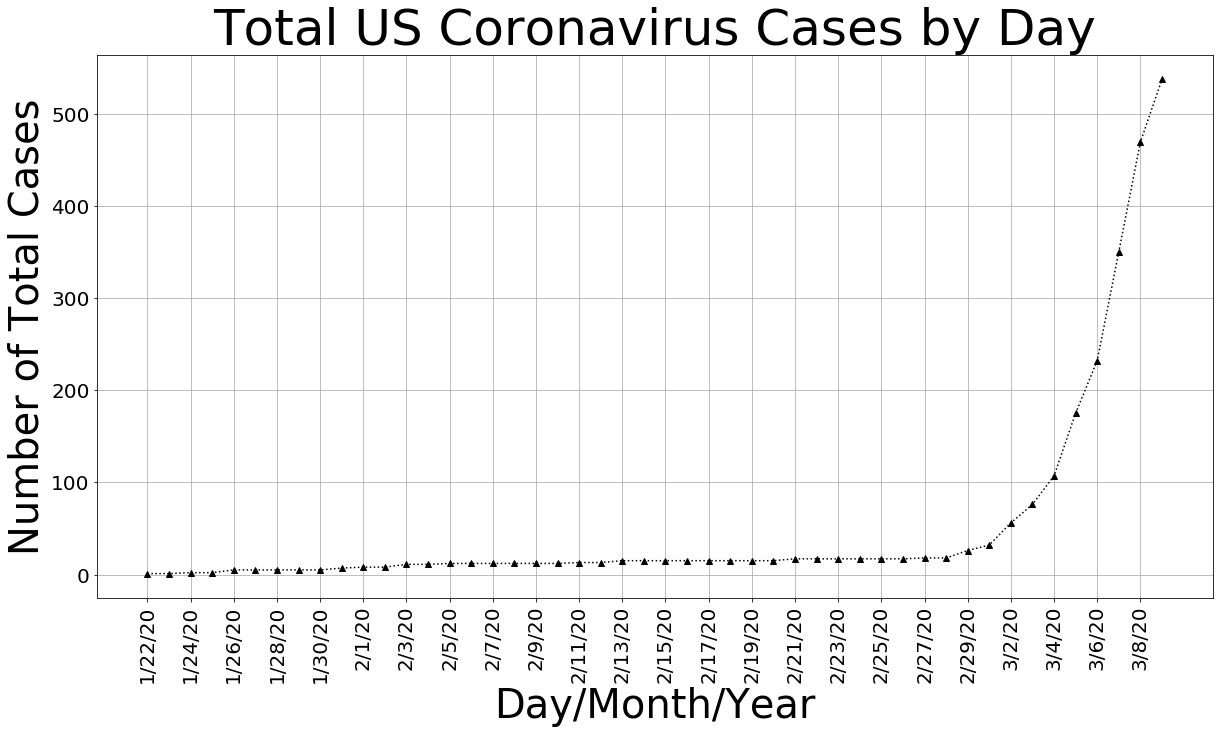

In [17]:
y = list(US_data[US_data.columns[4:-10]].sum())
x = list(US_data.columns[4:-10].values)

plt.plot(x,y,'^k:')
plt.title('Total US Coronavirus Cases by Day', size = 50)
plt.xlabel('Day/Month/Year', size = 40)
plt.ylabel('Number of Total Cases', size = 40)
plt.xticks(list(range(0, len(US_data.columns[4:-10].values), 2)), size = 20, rotation='vertical')
plt.yticks(size = 20)
plt.gcf().set_size_inches((20,10))
plt.grid(linestyle='-')
plt.savefig('Daily US Coronavirus Cases')

C:\Users\david\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()


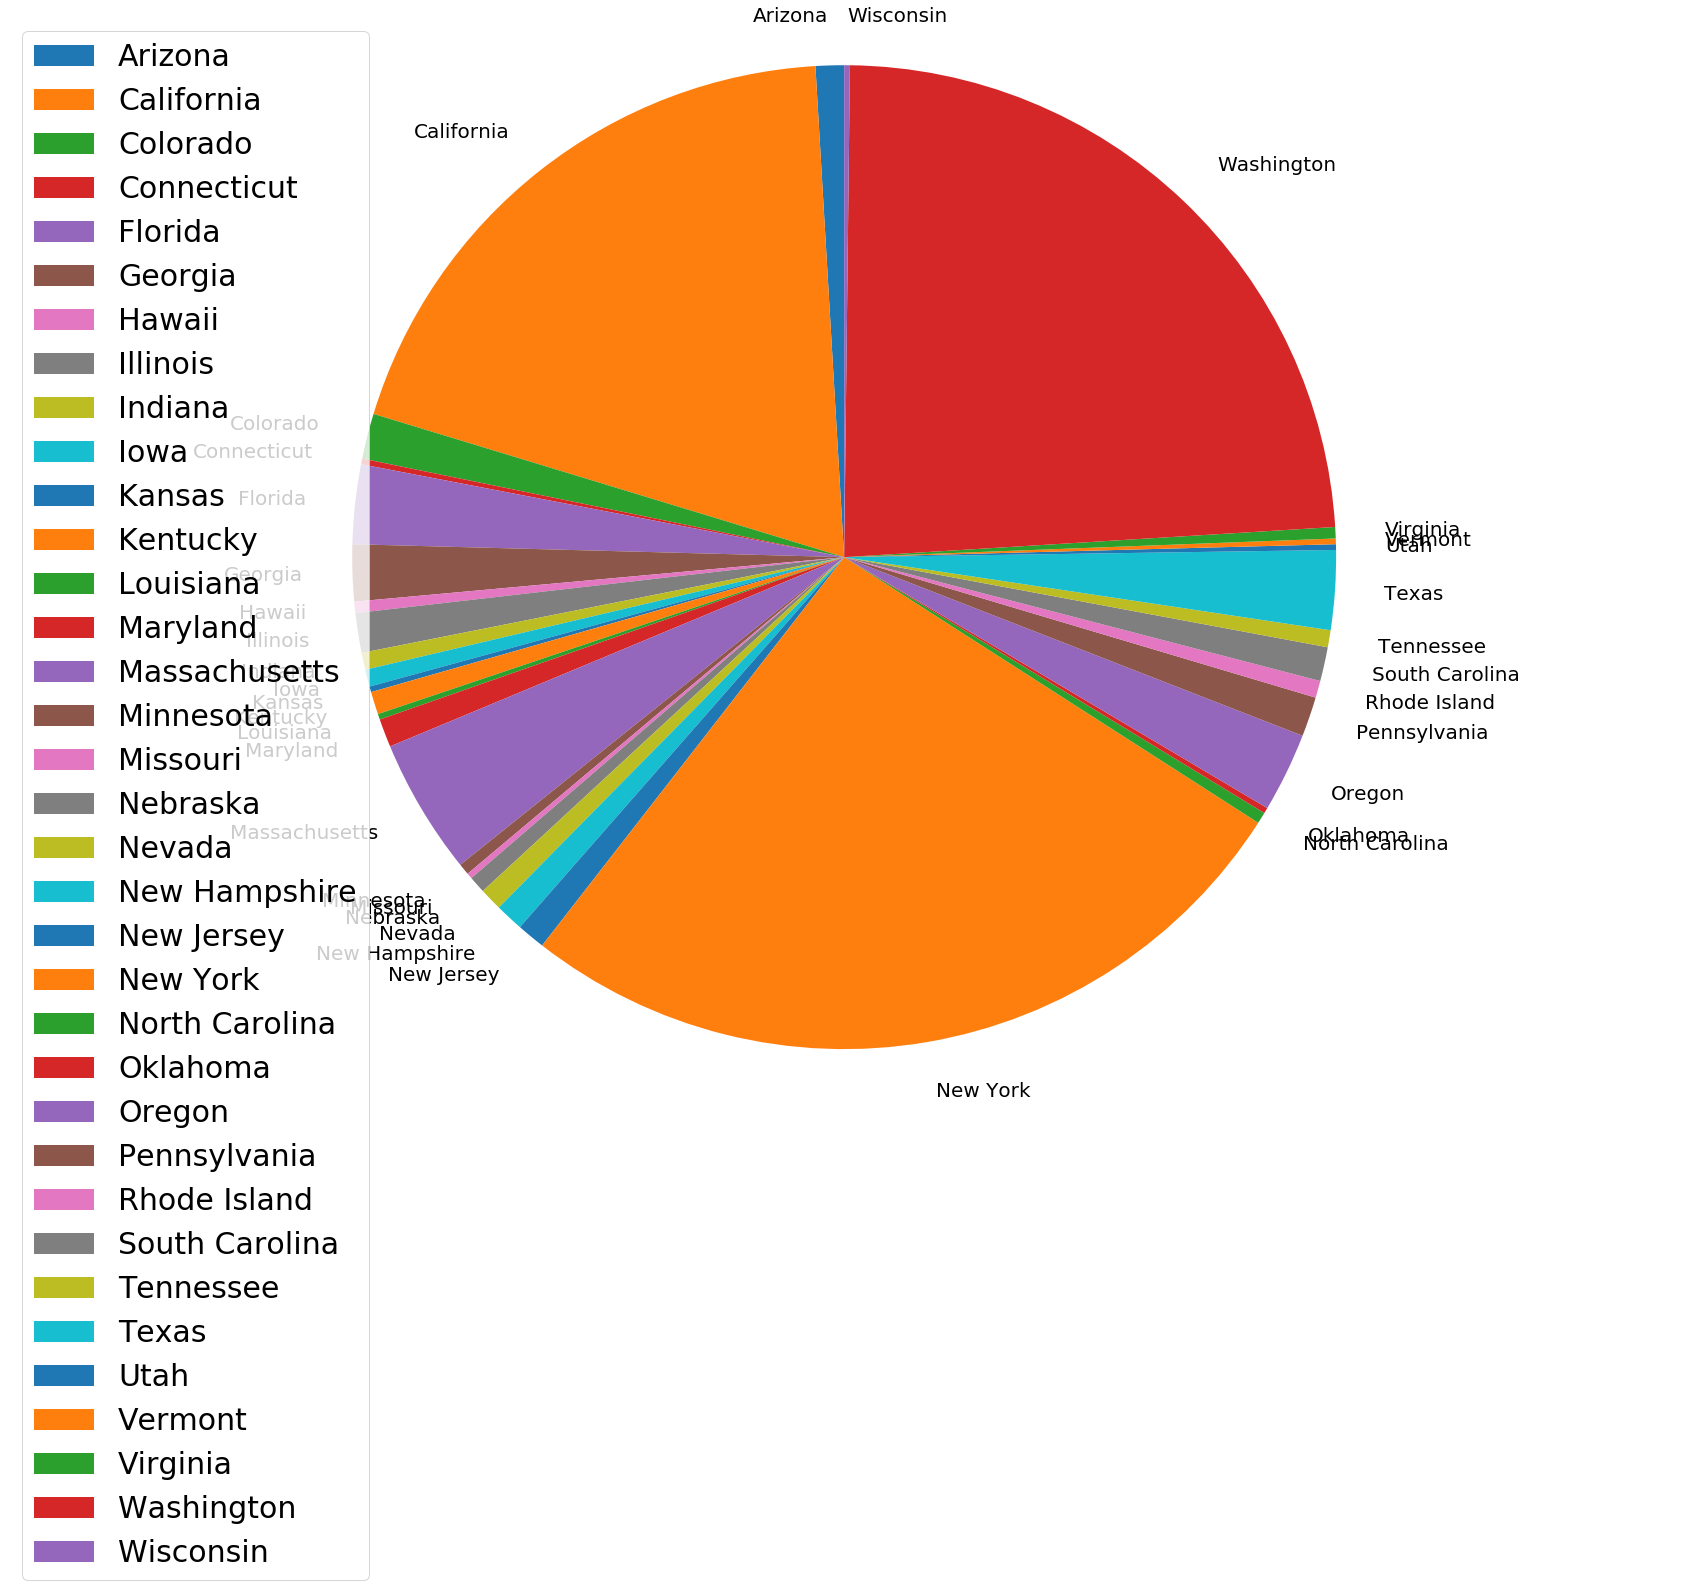

In [37]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
grouped_df = US_data.groupby(['State']).sum()
grouped_df = grouped_df.pivot_table(columns = 'State')
grouped_df = grouped_df.astype(int)
grouped_df = grouped_df[:-11]

labels = grouped_df.columns
sizes = grouped_df.tail(1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels = labels, startangle=90, textprops={'fontsize': 20})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.gcf().set_size_inches((30,20))
plt.rcParams['font.size'] = 9.0
plt.legend(labels, loc='upper left', prop={'size': 30});
plt.savefig('State PieChart')
plt.show()

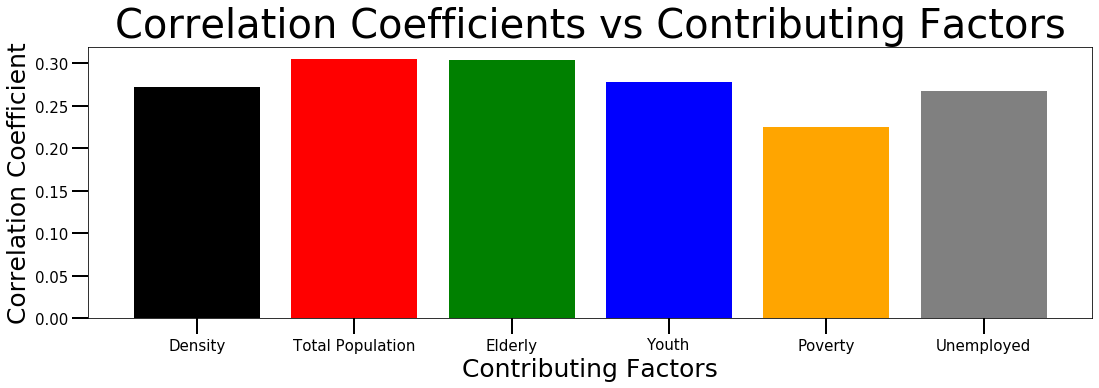

In [20]:
# Correlation between cumulative count per county and county population density
corr_count_density = US_data.iloc[:,-10].corr(US_data.iloc[:,-9], method='kendall')

# Correlation between the cumulative count per county and the total population
corr_count_total_population = US_data.iloc[:,-10].corr(US_data.iloc[:,-6], method='kendall')

# Correlation between the cumulative count and the elderly
corr_count_elderly = US_data.iloc[:,-10].corr(US_data.iloc[:,-4], method='kendall')

# Correlation between county cumulative count and the youth
corr_count_youth = US_data.iloc[:,-10].corr(US_data.iloc[:,-5], method='kendall')

# Correlation between county cumulative count and those in poverty
corr_count_poverty = US_data.iloc[:,-10].corr(US_data.iloc[:,-7], method='kendall')

# Correlation between county cumulative count and those who are unemployed
corr_count_unemployed = US_data.iloc[:,-10].corr(((US_data.iloc[:,-7]/100) * US_data.iloc[:,-6]), method='kendall')

data = {'Density': corr_count_density, 'Total Population': corr_count_total_population, 'Elderly': corr_count_elderly, 'Youth': corr_count_youth, 'Poverty': corr_count_poverty, 'Unemployed': corr_count_unemployed}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(figsize=(18,5))
axs.bar(names, values, align = 'center', color = ['black', 'red', 'green', 'blue', 'orange', 'gray'])
axs.set_ylabel('Correlation Coefficient', size = 25)
axs.set_xlabel('Contributing Factors', size = 25)
axs.tick_params(direction='out', length=16, width=2, labelsize = 15)
axs.set_title('Correlation Coefficients vs Contributing Factors', size = 40)

fig.savefig("Correlation Coefficients.png")

In [69]:
# Code sourced from https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9

## X usually means our input variables (or independent variables)
total_infected = pd.DataFrame(US_data['Total Population'] * R_o)

X = US_data['Risk Factor']
y = total_infected['Total Population'] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Total Population   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     30.61
Date:                Tue, 10 Mar 2020   Prob (F-statistic):           2.23e-07
Time:                        21:50:44   Log-Likelihood:                -1303.3
No. Observations:                 110   AIC:                             2611.
Df Residuals:                     108   BIC:                             2616.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6106.9203   4992.159      1.223      0.224   -3788.405     1.6e+04
Risk Factor   1.91e+04   3453.047      5.532      0.000    1.23e+04    2.59e+04
==============================================================================
Omnibus:                      135.327   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3330.971
Skew:                           4.316   Prob(JB):                         0.00
Kurtosis:                      28.539   Cond. No.                         2.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
US_data['']

County
Maricopa County         3
Pinal County            2
Riverside County        1
Contra Costa County    12
Orange County           4
                       ..
King County            83
Dane County             1
Jefferson Parish        1
Middlesex County        1
Chelan County           5
Name: 3/9/20, Length: 110, dtype: int64

In [21]:
risk_factor_df = master_df.groupby(['STATE']).sum()
risk_factor_df.drop('County ID', inplace = True, axis = 1)
# Finds the top 5 most-at-risk states
risk_factor_5_largest = risk_factor_df.nlargest(5, 'Risk Factor')
# Finds the bottom 5 most-at-risk-states
risk_factor_5_smallest = risk_factor_df.nsmallest(5, 'Risk Factor')